# Merging

Files needed = (Metro_MedianRentalPrice_1Bedroom.csv, Metro_MedianRentalPrice_Studio.csv, ml-latest-small.zip)

We will often find ourselves with variables spread across different datasets and files. We *merge* datasets together by matching up the two datasets on one or more variables. For example, I might have GDP data by country from the Penn World Tables, and demographic data by country from the World Bank. We would merge these two datasets and match up the observations by country. 




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### The data
We are working with data from [Zillow](https://www.zillow.com/research/data/) on rental listing prices. I would like to see how studio and one bedroom prices differ from each other across cities. Unfortunately, Zillow only lets me download one series at a time. (Hey, it's free data, I'm not complaining...) I have downloaded the studio and one bedroom rental listing pricing and now I would like to create one DataFrame with all the data. 

Time to get to work.

In [5]:
# The data come as csv files. Load them into separate DatFrames.
studios = pd.read_csv('Metro_MedianRentalPrice_Studio.csv')
onebeds = pd.read_csv('Metro_MedianRentalPrice_1Bedroom.csv')

In [6]:
# Always check out new data! You never know what could be lurking. 
print(studios.head())
print(studios.tail())

        RegionName  SizeRank  2010-01  2010-02  2010-03  2010-04  2010-05  \
0    United States         0   1300.0   1500.0   1500.0   1500.0   1500.0   
1     New York, NY         1      NaN   2000.0   2000.0   2100.0   2000.0   
2  Los Angeles, CA         2      NaN      NaN      NaN      NaN      NaN   
3      Chicago, IL         3      NaN   1500.0   1500.0   1500.0   1500.0   
4       Dallas, TX         4      NaN      NaN      NaN      NaN      NaN   

   2010-06  2010-07  2010-08   ...     2017-11  2017-12  2018-01  2018-02  \
0   1500.0   1500.0   1500.0   ...      1495.0   1500.0   1495.0   1500.0   
1   2125.0   2000.0   1950.0   ...      2300.0   2300.0   2300.0   2300.0   
2      NaN      NaN      NaN   ...      1800.0   1815.0   1795.0   1807.0   
3   1500.0   1500.0   1500.0   ...      1532.5   1500.0   1500.0   1500.0   
4      NaN      NaN      NaN   ...      1300.0   1300.0   1342.5   1330.0   

   2018-03  2018-04  2018-05  2018-06  2018-07  2018-08  
0   1500.0   152

In [4]:
print(onebeds.head())
print(onebeds.tail())

        RegionName  SizeRank  2010-02  2010-03  2010-04  2010-05  2010-06  \
0    United States         0      NaN   1200.0   1245.0   1200.0   1250.0   
1     New York, NY         1      NaN      NaN      NaN      NaN      NaN   
2  Los Angeles, CA         2      NaN   1380.0   1425.0   1420.0   1437.5   
3      Chicago, IL         3      NaN   1050.0   1100.0   1050.0   1075.0   
4       Dallas, TX         4      NaN      NaN      NaN      NaN      NaN   

   2010-07  2010-08  2010-09   ...     2017-11  2017-12  2018-01  2018-02  \
0   1200.0   1200.0   1044.0   ...      1400.0   1400.0   1400.0   1405.0   
1      NaN      NaN      NaN   ...      2095.0   2050.0   2050.0   2085.0   
2   1550.0   1600.0   1388.0   ...      1961.0   1947.0   1930.0   1950.0   
3    995.0    950.0   1090.0   ...      1525.0   1495.0   1477.0   1495.0   
4      NaN      NaN   1000.0   ...      1217.0   1205.0   1200.0   1242.0   

   2018-03  2018-04  2018-05  2018-06  2018-07  2018-08  
0   1425.0   143

A few things to note. 
1. There are more regions in the one-bedroom data (there are more rows)
2. Time is listed as columns

What do we want?
1. One DataFrame with one-bedroom and studio prices
2. A multiIndex of regions and time on the rows
3. Columns of studio and one bedroom prices

In [7]:
# Drop columns we don't need.
studios = studios.drop('SizeRank', axis=1)
onebeds = onebeds.drop('SizeRank', axis=1)

### Make the data long
We could assign indexes and reshape this using stack, or we can use melt and skip the indexing.

In [8]:
studios = studios.melt(id_vars=['RegionName']) # we spec RegionName as the grouping variable
studios.head()

,RegionName,variable,value
0,United States,2010-01,1300.0
1,"New York, NY",2010-01,NaN
2,"Los Angeles, CA",2010-01,NaN
3,"Chicago, IL",2010-01,NaN
4,"Dallas, TX",2010-01,NaN


### Rename variables

In [9]:
studios.rename(columns={'RegionName':'region', 'variable':'date', 'value':'studio_price'}, inplace=True)
studios.head()

,region,date,studio_price
0,United States,2010-01,1300.0
1,"New York, NY",2010-01,NaN
2,"Los Angeles, CA",2010-01,NaN
3,"Chicago, IL",2010-01,NaN
4,"Dallas, TX",2010-01,NaN


### Repeat for one bedroom data
The studio data looks great. Get the one bedroom data set up.

In [10]:
onebeds = onebeds.melt(id_vars = ['RegionName'])
onebeds.rename(columns={'RegionName':'region', 'variable':'date', 'value':'onebed_price'}, inplace=True)
onebeds.head()

,region,date,onebed_price
0,United States,2010-02,NaN
1,"New York, NY",2010-02,NaN
2,"Los Angeles, CA",2010-02,NaN
3,"Chicago, IL",2010-02,NaN
4,"Dallas, TX",2010-02,NaN


### Merge the two DataFrames into one DataFrame
We want to match the two DataFrames together according to the region-date pairs. 
In database-ese, we refer to variables we are matching as **keys.** So, in our case, the keys are region and date. 

We also need to tell pandas how to treat keys that are not present in both databases. The different types of 'join' (more database-ese) are
1. **inner**: keep the intersection of the keys
2. **left**: keep all the keys from the left DataFrame
3. **right**: keep all the keys from right DataFrame
4. **outer**: keep all the keys from both DataFrames

We specify the join type with the `how` parameter. The default is inner, but for sanity's sake, be explicit about your join.

In [17]:

# left and right specify the DataFrames to merge, on specifies the keys (we are using two keys)
rental_prices = pd.merge(left=studios, right=onebeds, on=['region', 'date'], how='inner')
rental_prices

,region,date,studio_price,onebed_price
0,United States,2010-02,1500.0,NaN
1,"New York, NY",2010-02,2000.0,NaN
2,"Los Angeles, CA",2010-02,NaN,NaN
3,"Chicago, IL",2010-02,1500.0,NaN
4,"Dallas, TX",2010-02,NaN,NaN
5,"Philadelphia, PA",2010-02,1500.0,NaN
6,"Houston, TX",2010-02,NaN,NaN
7,"Washington, DC",2010-02,1650.0,NaN
8,"Miami, FL",2010-02,NaN,1300.0
9,"Atlanta, GA",2010-02,NaN,999.5


### Set the index to region and date

In [18]:
rental_prices['date'] = pd.to_datetime(rental_prices['date'])   # set the date column to datetime objects

rental_prices.set_index(['region', 'date'], inplace=True) # set up the index and sort it!
rental_prices.sort_index(axis=0, inplace=True)
rental_prices.head()

studio_price  onebed_price
region      date                                  
Abilene, TX 2010-02-01           NaN           NaN
            2010-03-01           NaN           NaN
            2010-04-01           NaN           NaN
            2010-05-01           NaN           NaN
            2010-06-01           NaN           NaN

In [19]:
rental_prices.loc['United States']

,studio_price,onebed_price
date,,
2010-02-01,1500.0,NaN
2010-03-01,1500.0,1200.0
2010-04-01,1500.0,1245.0
2010-05-01,1500.0,1200.0
2010-06-01,1500.0,1250.0
2010-07-01,1500.0,1200.0
2010-08-01,1500.0,1200.0
2010-09-01,1450.0,1044.0
2010-10-01,1450.0,1095.0


### Try an outer merge
Notice that 2010-01 is missing, even though the studio data have an entry for it. Let's try an outer join.

In [20]:
# The only difference from the previous merge is the switch to 'outer'
rental_prices = pd.merge(left=studios, right=onebeds, on=['region', 'date'], how='outer')

rental_prices['date'] = pd.to_datetime(rental_prices['date'])
rental_prices.set_index(['region', 'date'], inplace=True)
rental_prices.sort_index(axis=0, inplace=True)

rental_prices.loc['United States']

,studio_price,onebed_price
date,,
2010-01-01,1300.0,NaN
2010-02-01,1500.0,NaN
2010-03-01,1500.0,1200.0
2010-04-01,1500.0,1245.0
2010-05-01,1500.0,1200.0
2010-06-01,1500.0,1250.0
2010-07-01,1500.0,1200.0
2010-08-01,1500.0,1200.0
2010-09-01,1450.0,1044.0


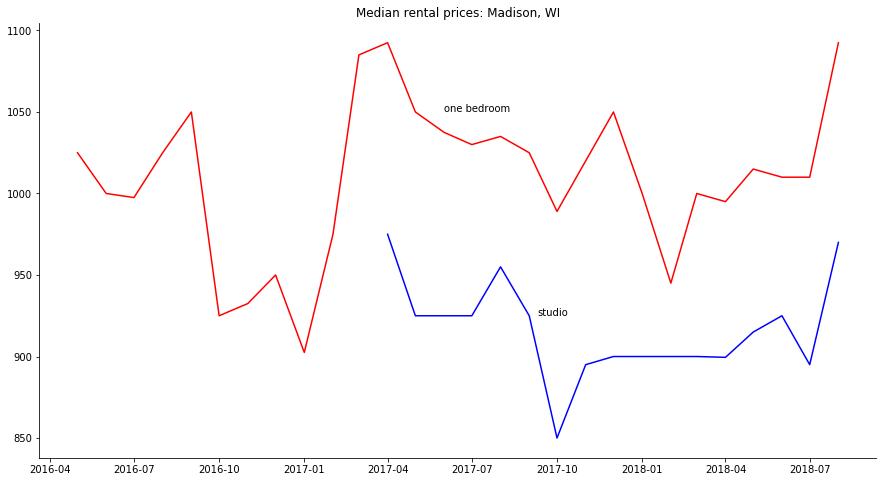

In [21]:
# Peel off the data for Madison
mad = rental_prices.loc['Madison, WI']

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(mad.index, mad['studio_price'], color='blue')
ax.plot(mad.index, mad['onebed_price'], color='red')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Median rental prices: Madison, WI')
ax.text('06/01/2017', 1050, 'one bedroom')
ax.text('09/10/2017', 925, 'studio')

plt.show()

I wish we had a longer time series. Not much to see here. 

The Florida markets have much longer time series. Let's plot.

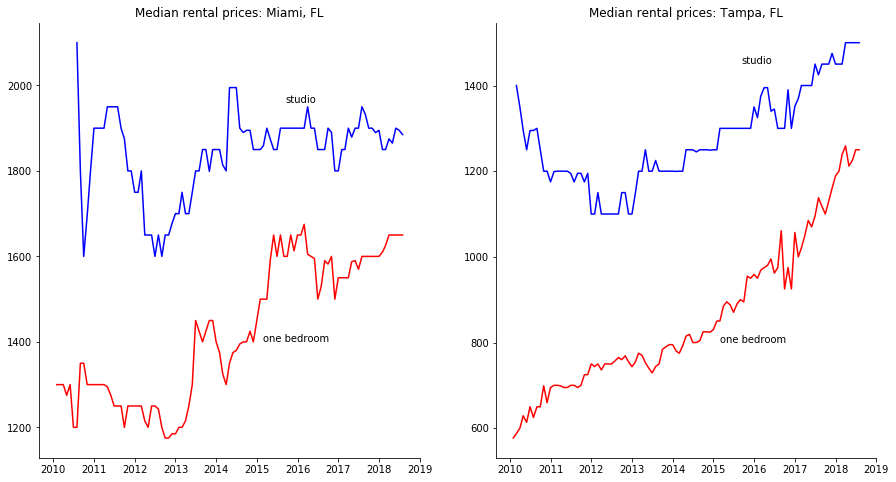

In [22]:

miami = rental_prices.loc['Miami, FL']
tampa = rental_prices.loc['Tampa, FL']

fig, ax = plt.subplots(1, 2, figsize=(15,8))

ax[0].plot(miami.index, miami['studio_price'], color='blue')
ax[0].plot(miami.index, miami['onebed_price'], color='red')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[0].set_title('Median rental prices: Miami, FL')
ax[0].text('03/01/2015', 1400, 'one bedroom')
ax[0].text('09/10/2015', 1960, 'studio')

ax[1].plot(tampa.index, tampa['studio_price'], color='blue')
ax[1].plot(tampa.index, tampa['onebed_price'], color='red')

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[1].set_title('Median rental prices: Tampa, FL')
ax[1].text('03/01/2015', 800, 'one bedroom')
ax[1].text('09/10/2015', 1450, 'studio')

plt.show()

Interesting...one bedroom apartments are cheaper than studios. Maybe this reflects studios being located in more desirable neighborhoods? 

## Practice
Head over to [MovieLens](https://grouplens.org/datasets/movielens/) and download the ml-latest-small dataset. It will come as a zipped file. Put it in your user drive (and cwd) and unzip it. You will find 5 files. 

1. Load the movies.csv and the ratings.csv files as DataFrames
2. What size are the two DataFrames?


In [24]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
print(movies.shape)
print(ratings.shape)
print(movies.head())
print(ratings.head())

(9742, 3)
(100836, 4)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


3. Merge the two files on the movieId. What kind of join should you use? We have several ratings per movie. 
4. What size is the resulting DataFrame?

In [111]:
movies_ratings = pd.merge(left=movies, right=ratings, on=["movieId"], how="outer")
print(movies_ratings.head())
print("\n")
print("The size of the resulting DataFrame is", movies_ratings.shape)

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating     timestamp  
0     1.0     4.0  9.649827e+08  
1     5.0     4.0  8.474350e+08  
2     7.0     4.5  1.106636e+09  
3    15.0     2.5  1.510578e+09  
4    17.0     4.5  1.305696e+09  


The size of the resulting DataFrame is (100854, 6)


5. Create a histogram of the ratings. Use 10 bins. Use the density=True parameter to plot the density rather than the counts.

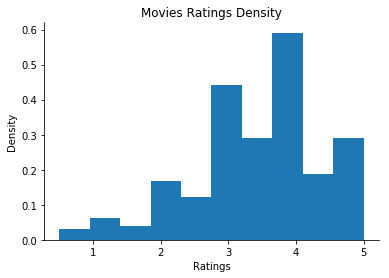

In [112]:
fig, ax = plt.subplots()

ax.hist(movies_ratings.rating.dropna(), bins = 10, density = True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Movies Ratings Density")
ax.set_xlabel("Ratings")
ax.set_ylabel("Density")

plt.show()

6. Load the 'tags.csv' file
7. Merge it into your data. What keys should you use? What type of join?

In [115]:
tags = pd.read_csv("tags.csv")
mrt = pd.merge(left = movies_ratings, right = tags, on = ["movieId", "userId"], how = "outer")
mrt.head()

,movieId,title,genres,userId,rating,timestamp_x,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08,NaN,NaN
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08,NaN,NaN
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09,NaN,NaN
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09,NaN,NaN
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09,NaN,NaN


Let's get a look at the kinds of tags we have. Try the code below, which introduces us to the `value_counts()` method of DataFrame.

In [116]:
print(mrt['tag'].value_counts())

In Netflix queue          131
atmospheric                36
superhero                  24
thought-provoking          24
Disney                     23
surreal                    23
funny                      23
religion                   22
psychology                 21
quirky                     21
sci-fi                     21
dark comedy                21
suspense                   20
visually appealing         19
crime                      19
twist ending               19
politics                   18
mental illness             16
music                      16
time travel                16
aliens                     15
comedy                     15
dark                       15
dreamlike                  14
mindfuck                   14
space                      14
heist                      13
black comedy               13
emotional                  13
anime                      12
                         ... 
ben stiller                 1
convent                     1
1990s     

I don't know what atmospheric means, so let's look at the second most used tag, 'superhero'.
8. Compute the average rating for all movies and for movies tagged 'superhero'


In [117]:
mrt_tags = mrt.set_index("tag")
mrt_tags.sort_index(axis = 0, inplace = True)
mean_all = round(mrt.rating.mean(), ndigits = 2)
mean_sup = round(mrt_tags.loc["superhero", "rating"].mean(), ndigits = 2)
print("The average rating for all movies is", mean_all)
print("The average rating for all movies with 'superhero' tag is", mean_sup)

The average rating for all movies is 3.51
The average rating for all movies with 'superhero' tag is 3.63


9. Let's see how the ratings of superhero movies compare to all movies. We will plot two histograms on the same axes.
    1. Plot the histogram of movies tagged 'superhero'. Use 10 bins. Make the plot blue.
    2. Plot the histogram of all movies (like you did for question 5). Use 10 bins. make the plot red.
    3. Add a legend
    4. Add the mean ratings for all movies and for superhero movies as text to the histogram

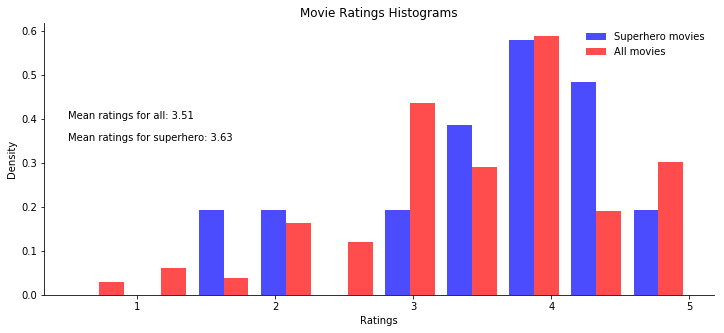

In [118]:
fig, ax = plt.subplots(figsize = (12, 5))

ax.hist([mrt_tags.loc["superhero"].rating.dropna(), mrt_tags.rating.dropna()], 
        bins = 10, 
        color = ["blue", "red"], 
        alpha = .7, 
        density = True, 
        label = ["Superhero movies", "All movies"])

ax.legend(frameon = False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.text(x = .5, y = .4, s = "Mean ratings for all: " + str(mean_all))
ax.text(x = .5, y = .35, s = "Mean ratings for superhero: " + str(mean_sup))

ax.set_title("Movie Ratings Histograms")
ax.set_xlabel("Ratings")
ax.set_ylabel("Density")

plt.show()